# Compare URL SVM classification with raw and decomposed data

In [146]:
import random
import itertools
from joblib import Memory
from sklearn import svm
import sklearn.datasets as sd
import scipy.sparse as sparse

In [147]:
import matplotlib.pyplot as plt
import h5py
import numpy as np
import pandas as pd

In [6]:
from dask_ml.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

In [7]:
def random_index(dataset, old_index = ""):
    new_index = random.randint(0, len(dataset))
    while old_index == new_index:
         new_index = random.randint(0, len(dataset))
    return new_index

In [8]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [153]:
def plot_classification_report(classificationReport,
                               title='Classification report',
                               cmap='RdBu'):

    classificationReport = classificationReport.replace('\n\n', '\n')
    classificationReport = classificationReport.replace(' / ', '/')
    lines = classificationReport.split('\n')

    classes, plotMat, support, class_names = [], [], [], []
    for line in lines[1:-4]:  # if you don't want avg/total result, then change [1:] into [1:-1]
        t = line.strip().split()
        if len(t) < 2:
            continue
        classes.append(t[0])
        v = [float(x) for x in t[1: len(t) - 1]]
        support.append(int(t[-1]))
        class_names.append(t[0])
        plotMat.append(v)

    plotMat = np.array(plotMat)
    xticklabels = ['Precision', 'Recall', 'F1-score']
    yticklabels = ['{0} ({1})'.format(class_names[idx], sup)
                   for idx, sup in enumerate(support)]

    plt.imshow(plotMat, interpolation='nearest', cmap=cmap, aspect='auto')
    plt.title(title)
    plt.colorbar()
    plt.xticks(np.arange(3), xticklabels, rotation=45)
    plt.yticks(np.arange(len(classes)), yticklabels)

    upper_thresh = plotMat.min() + (plotMat.max() - plotMat.min()) / 10 * 8
    lower_thresh = plotMat.min() + (plotMat.max() - plotMat.min()) / 10 * 2
    for i, j in itertools.product(range(plotMat.shape[0]), range(plotMat.shape[1])):
        plt.text(j, i, format(plotMat[i, j], '.2f'),
                 horizontalalignment="center",
                 color="white" if (plotMat[i, j] > upper_thresh or plotMat[i, j] < lower_thresh) else "black")

    plt.ylabel('Metrics')
    plt.xlabel('Classes')
    plt.tight_layout()

In [9]:
%matplotlib inline

## Creating the dataset

In [10]:
filelist = ["./url_svmlight/Day%s.svm" % i for i in range(0,121)]

In [11]:
mem = Memory("./cache")

In [12]:
@mem.cache
def get_data():
    data = sd.load_svmlight_files(filelist)
    return data

In [13]:
data = get_data()

In [14]:
days = np.array([(data[i], data[i+1]) for i in range(0, len(data)) if i%2==0])

days

In [15]:
x = np.array([day[0] for day in days])

In [16]:
y = np.array([day[1] for day in days])

Removing the only two days with a different shape, so that each random sample will be of the same dimension

In [17]:
for i in range(0, len(x)):
    if x[i].shape != (20000, 3231961):
        print(i)

0
45


In [18]:
x = np.delete(x, 0)
x = np.delete(x, 44)
y = np.delete(y, 0)
y = np.delete(y, 44)

In [19]:
for i in range(0, len(x)):
    if x[i].shape != (20000, 3231961):
        print(i)

In [17]:
x

array([<20000x3231961 sparse matrix of type '<class 'numpy.float64'>'
	with 2304202 stored elements in Compressed Sparse Row format>,
       <20000x3231961 sparse matrix of type '<class 'numpy.float64'>'
	with 2300129 stored elements in Compressed Sparse Row format>,
       <20000x3231961 sparse matrix of type '<class 'numpy.float64'>'
	with 2302278 stored elements in Compressed Sparse Row format>,
       <20000x3231961 sparse matrix of type '<class 'numpy.float64'>'
	with 2298268 stored elements in Compressed Sparse Row format>,
       <20000x3231961 sparse matrix of type '<class 'numpy.float64'>'
	with 2305094 stored elements in Compressed Sparse Row format>,
       <20000x3231961 sparse matrix of type '<class 'numpy.float64'>'
	with 2318747 stored elements in Compressed Sparse Row format>,
       <20000x3231961 sparse matrix of type '<class 'numpy.float64'>'
	with 2350415 stored elements in Compressed Sparse Row format>,
       <20000x3231961 sparse matrix of type '<class 'numpy.flo

In [18]:
y

array([array([-1., -1., -1., ..., -1., -1., -1.]),
       array([-1., -1.,  1., ...,  1.,  1.,  1.]),
       array([ 1.,  1.,  1., ...,  1., -1., -1.]),
       array([-1.,  1.,  1., ..., -1.,  1.,  1.]),
       array([-1.,  1.,  1., ...,  1., -1., -1.]),
       array([-1., -1., -1., ..., -1., -1.,  1.]),
       array([-1., -1.,  1., ...,  1., -1., -1.]),
       array([ 1., -1., -1., ...,  1., -1., -1.]),
       array([-1., -1., -1., ...,  1., -1., -1.]),
       array([-1., -1.,  1., ..., -1.,  1.,  1.]),
       array([-1., -1., -1., ...,  1.,  1., -1.]),
       array([-1., -1., -1., ..., -1., -1., -1.]),
       array([-1.,  1.,  1., ...,  1., -1., -1.]),
       array([-1.,  1., -1., ...,  1., -1., -1.]),
       array([ 1.,  1.,  1., ..., -1., -1., -1.]),
       array([-1.,  1., -1., ...,  1.,  1.,  1.]),
       array([ 1., -1.,  1., ...,  1., -1.,  1.]),
       array([ 1., -1., -1., ..., -1., -1.,  1.]),
       array([-1., -1., -1., ..., -1., -1., -1.]),
       array([-1., -1., -1., ..

## Exploratory view on the URLs

In [25]:
n_samples = len(x) * x[0].shape[0]
n_features = x[0].shape[1]
n_classes = len(np.unique(y[0]))

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)

Total dataset size:
n_samples: 2380000
n_features: 3231961
n_classes: 2


In [20]:
totalurls = np.empty(0)

for day in days:
    totalurls =np.append(totalurls, day[1])

In [21]:
totalurls

array([-1., -1., -1., ...,  1., -1., -1.])

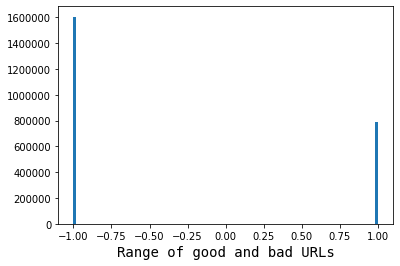

In [23]:
plt.hist(totalurls, 100)
plt.xlabel("Range of good and bad URLs", fontdict={'fontsize': 14, 'family': 'monospace'})
plt.show()

## Fitting model on raw data

Here we try to train and test a SVM model with the raw data of our dataset, in particular we take one random set of days for training and one for testing. From the training set of days we choose one random day and pass it as an input to train the model, the number of data used to train the model is 20000. Then we apply the GridSearch model on our SVM to find the best parameters ( C value and Kernel ) for our data. Finally we test the model on some random days taken from the test set.

### Model definition

In [114]:
estimator = svm.SVC(gamma='auto', random_state=0, probability=True)

param_grid = {
    'C': [0.1, 1.0, 20.0, 100.0],
    'kernel': ['rbf', 'poly', 'linear'],
}

grid_search = GridSearchCV(estimator, param_grid, n_jobs=-1, cv=2)

### Train test split

In [115]:
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.3)

/home/giordano/anaconda3/envs/da2019/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


### Training the model

First apply grid search model to find the best parameters to svm

In [116]:
grid_search = GridSearchCV(estimator, param_grid, n_jobs=-1, cv=2)

In [117]:
index = random_index(x_train) 

In [118]:
%time grid_search.fit(x_train[index], y_train[index])

CPU times: user 1h 53min 18s, sys: 11.5 s, total: 1h 53min 30s
Wall time: 30min 29s


GridSearchCV(cache_cv=True, cv=2, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=0, shrinking=True, tol=0.001,
  verbose=False),
       iid=True, n_jobs=-1,
       param_grid={'C': [0.1, 1.0, 20.0, 100.0], 'kernel': ['rbf', 'poly', 'linear']},
       refit=True, return_train_score='warn', scheduler=None, scoring=None)

Here we can see the result of the cross validation test for the various combination of the parameters and some other informations

In [119]:
pd.DataFrame(grid_search.cv_results_)

/home/giordano/anaconda3/envs/da2019/lib/python3.6/site-packages/dask_ml/model_selection/utils.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in sklearn 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/giordano/anaconda3/envs/da2019/lib/python3.6/site-packages/dask_ml/model_selection/utils.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in sklearn 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/giordano/anaconda3/envs/da2019/lib/python3.6/site-packages/dask_ml/model_selection/utils.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in sklearn 0.21. If you need training scores, please set return_train_score=Tru

,params,mean_fit_time,std_fit_time,mean_score_time,std_score_time,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,mean_train_score,std_train_score,param_C,param_kernel
0,"{'C': 0.1, 'kernel': 'rbf'}",308.369061,8.702819,56.811756,0.690229,0.631437,0.631463,0.63145,0.000013,6,0.631463,0.631437,0.631450,1.314500e-05,0.1,rbf
1,"{'C': 0.1, 'kernel': 'poly'}",291.262082,11.585879,49.855733,1.102404,0.631437,0.631463,0.63145,0.000013,6,0.631463,0.631437,0.631450,1.314500e-05,0.1,poly
2,"{'C': 0.1, 'kernel': 'linear'}",49.869594,3.336660,7.730680,0.330571,0.975102,0.980298,0.97770,0.002598,1,0.997500,0.997500,0.997500,2.500000e-07,0.1,linear
3,"{'C': 1.0, 'kernel': 'rbf'}",313.701535,8.804138,52.670144,1.671675,0.631437,0.631463,0.63145,0.000013,6,0.631463,0.631437,0.631450,1.314500e-05,1,rbf
4,"{'C': 1.0, 'kernel': 'poly'}",279.247259,6.617895,46.138575,0.086304,0.631437,0.631463,0.63145,0.000013,6,0.631463,0.631437,0.631450,1.314500e-05,1,poly
5,"{'C': 1.0, 'kernel': 'linear'}",51.039631,3.784847,7.793320,0.440717,0.973603,0.980498,0.97705,0.003448,2,1.000000,1.000000,1.000000,0.000000e+00,1,linear
6,"{'C': 20.0, 'kernel': 'rbf'}",318.811352,10.993538,54.507265,2.195584,0.631437,0.631463,0.63145,0.000013,6,0.631463,0.631437,0.631450,1.314500e-05,20,rbf
7,"{'C': 20.0, 'kernel': 'poly'}",273.386728,8.622309,47.079418,1.577512,0.631437,0.631463,0.63145,0.000013,6,0.631463,0.631437,0.631450,1.314500e-05,20,poly
8,"{'C': 20.0, 'kernel': 'linear'}",51.538848,3.339830,8.123403,0.236409,0.973603,0.980398,0.97700,0.003398,3,1.000000,1.000000,1.000000,0.000000e+00,20,linear
9,"{'C': 100.0, 'kernel': 'rbf'}",291.251503,35.140097,48.511955,6.780016,0.703530,0.843684,0.77360,0.070077,5,0.807781,0.787321,0.797551,1.022976e-02,100,rbf


The choosen parameters are C = 0.1 and kernel = linear

In [120]:
grid_search.best_params_

{'C': 0.1, 'kernel': 'linear'}

In [121]:
grid_search.best_estimator_

SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=0, shrinking=True, tol=0.001,
  verbose=False)

Here we try to predict the quality of some random urls and rank the goodness of the results 

In [140]:
%time result = grid_search.predict(x_test[25])

CPU times: user 17.6 s, sys: 411 µs, total: 17.6 s
Wall time: 17.6 s


In [143]:
print(classification_report(y_test[25], result))

              precision    recall  f1-score   support

        -1.0       0.98      0.98      0.98     13097
         1.0       0.95      0.97      0.96      6903

   micro avg       0.97      0.97      0.97     20000
   macro avg       0.97      0.97      0.97     20000
weighted avg       0.97      0.97      0.97     20000



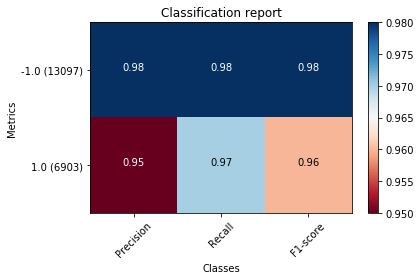

In [154]:
plot_classification_report(classification_report(y_test[25], result))

Normalized confusion matrix
[[0.97579598 0.02420402]
 [0.0318702  0.9681298 ]]


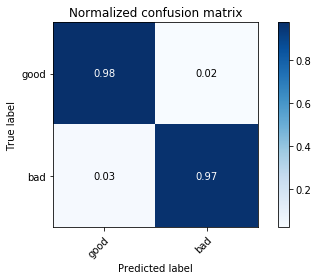

In [124]:
plot_confusion_matrix(y_test[25], result, ('good','bad'), normalize=True)

In [155]:
pred = grid_search.predict(x_test[27])

In [134]:
print(classification_report(y_test[27], pred))

              precision    recall  f1-score   support

        -1.0       0.98      0.99      0.99     13578
         1.0       0.97      0.97      0.97      6422

   micro avg       0.98      0.98      0.98     20000
   macro avg       0.98      0.98      0.98     20000
weighted avg       0.98      0.98      0.98     20000



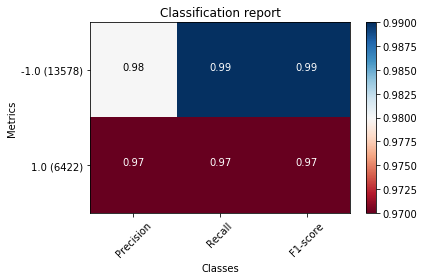

In [156]:
plot_classification_report(classification_report(y_test[27], pred))

Normalized confusion matrix
[[0.98652232 0.01347768]
 [0.03207723 0.96792277]]


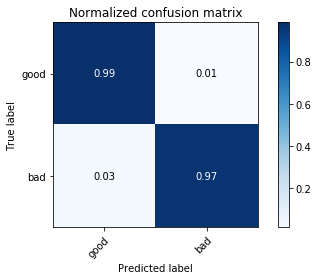

In [135]:
plot_confusion_matrix(y_test[27], pred, ('good','bad'), normalize=True)

In [157]:
index = random_index(x_test)
pred = grid_search.predict(x_test[index])

In [137]:
print(classification_report(y_test[index], pred))

              precision    recall  f1-score   support

        -1.0       0.98      0.97      0.97     13555
         1.0       0.94      0.95      0.95      6445

   micro avg       0.96      0.96      0.96     20000
   macro avg       0.96      0.96      0.96     20000
weighted avg       0.97      0.96      0.96     20000



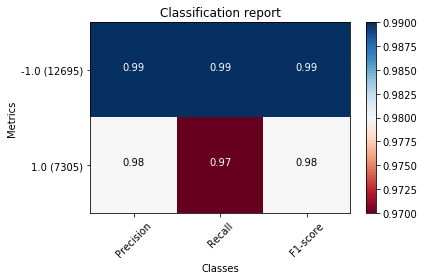

In [158]:
plot_classification_report(classification_report(y_test[index], pred))

Normalized confusion matrix
[[0.97248248 0.02751752]
 [0.05089216 0.94910784]]


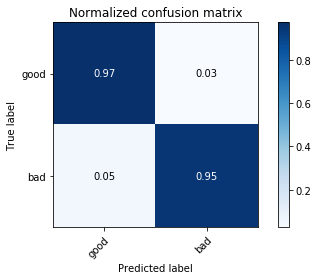

In [138]:
plot_confusion_matrix(y_test[index], pred, ('good','bad'), normalize=True)

So we can see, looking to the classification reports and the confusion matrixes, that the model is good trained and is able to predict the quality of random URLs with very low error rates

## Test on decomposed data

Here instead we try to apply SVM on dimensionally reducted data and see if the model is equally able to predict the quality of the URLs with a very low error score in a shorter time. Since we are dealing with sparse attributes we can not compute PCA to reduce the dimension of our dataset, instead we will use the Truncated SVD model which is a particular kind of PCA, used to reduce the dimension of sparse data.

### Truncated SVD

In [164]:
from sklearn.decomposition import TruncatedSVD

Lets first plot the data for day 0 with a 2 components decomposition

In [165]:
day0 = TruncatedSVD().fit_transform(x[0])

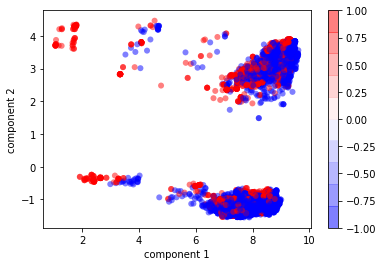

In [163]:
plt.scatter(day0[:, 0], day0[:, 1],
            c=y[0], edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('bwr', 10))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

Since Truncated SVD is a model very complex computationally we are not able to reduce the dataset of only few components. Instead what we want to see is that, keeping only few components, we are able to explain much of the variance of the original dataset. For this test we are projecting our original dataset on a space made of only 25 eigenvectors.

In [29]:
svd = TruncatedSVD(n_components=25).fit(x[0])

Cumulative explained variance: 0.46161455754368325


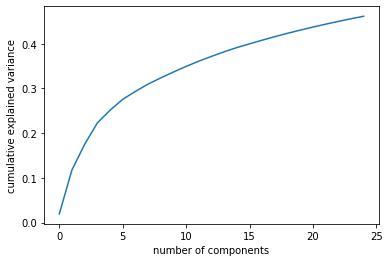

In [32]:
print("Cumulative explained variance:",sum(svd.explained_variance_ratio_))
plt.plot(np.cumsum(svd.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

Almost 45% of the original variance for day 0 is explained by these new components

In [166]:
mem_svd = Memory('./cache_svd')

In [167]:
#Save the result of the decomposition on a cache file, so that the future calls are faster
@mem_svd.cache
def get_svd_array(dataset):
    svd = TruncatedSVD(n_components=25)
    svd_dataset = np.array([svd.fit_transform(day) for day in dataset])
    return svd_dataset

In [168]:
svd_x = get_svd_array(x)

In [169]:
n_samples = len(svd_x) * svd_x[0].shape[0]
n_features = svd_x[0].shape[1]
n_classes = len(np.unique(y[0]))

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)

Total dataset size:
n_samples: 2380000
n_features: 25
n_classes: 2


Again here we split our dataset in training and testing and run the SVM classification on these data. We are using the same parameters for the SVM as before, since putting C=1 lets the model train for a time larger then before, making our analysis useless.

In [170]:
x_train, x_test, y_train, y_test = train_test_split(svd_x, y, train_size=0.3)

/home/giordano/anaconda3/envs/da2019/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [87]:
estimator = svm.SVC(C=0.1, kernel='linear', gamma='auto', random_state=0, probability=True)

In [88]:
%time estimator.fit(x_train[0], y_train[0])

CPU times: user 14.1 s, sys: 6.85 ms, total: 14.1 s
Wall time: 14.1 s


SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=0, shrinking=True, tol=0.001,
  verbose=False)

In [89]:
pred = estimator.predict(x_test[0])

In [90]:
print(classification_report(y_test[0], pred, target_names=['good', 'bad']))

              precision    recall  f1-score   support

        good       0.81      0.72      0.76     15255
         bad       0.34      0.46      0.39      4745

   micro avg       0.66      0.66      0.66     20000
   macro avg       0.58      0.59      0.58     20000
weighted avg       0.70      0.66      0.67     20000



Normalized confusion matrix
[[0.72081285 0.27918715]
 [0.53972603 0.46027397]]


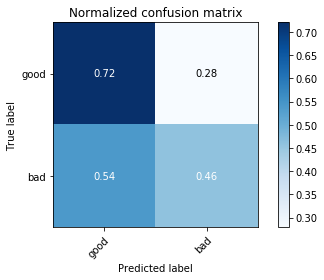

In [91]:
plot_confusion_matrix(y_test[0], pred, ('good','bad'), normalize=True)

In [92]:
pred = estimator.predict(x_test[1])

In [93]:
print(classification_report(y_test[1], pred, target_names=['good', 'bad']))

              precision    recall  f1-score   support

        good       0.65      0.74      0.69     12244
         bad       0.47      0.37      0.42      7756

   micro avg       0.60      0.60      0.60     20000
   macro avg       0.56      0.56      0.55     20000
weighted avg       0.58      0.60      0.58     20000



Normalized confusion matrix
[[0.73725907 0.26274093]
 [0.62661166 0.37338834]]


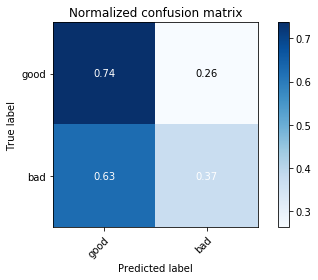

In [94]:
plot_confusion_matrix(y_test[1], pred, ('good','bad'), normalize=True)

In [112]:
index = random_index(x_train, 0)
pred = estimator.predict(x_test[5])

              precision    recall  f1-score   support

        good       0.81      0.81      0.81     14266
         bad       0.53      0.54      0.54      5734

   micro avg       0.73      0.73      0.73     20000
   macro avg       0.67      0.68      0.67     20000
weighted avg       0.73      0.73      0.73     20000

Normalized confusion matrix
[[0.81094911 0.18905089]
 [0.46076038 0.53923962]]


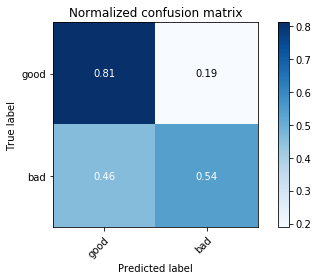

In [113]:
print(classification_report(y_test[5], pred, target_names=['good', 'bad']))
plot_confusion_matrix(y_test[5], pred, ('good','bad'), normalize=True)

So here we can see that, although the model requires a very little time for training and testing, he is not able to predict the quality of an URL with the same accuracy as before

## Conclusions

<div>In this project we have analyzed the behaviour of the SVM classification model on a very huge dataset. 
Sampling is the only way to manage these data, since is impossible for us to do computations on the entire dataset at the same time.</div> 
<div>
Training and testing the model on 20000 random samples of the raw data is a bit heavy computationally but gives us a very good model for predicting the quality of an URL.
</div>
<div>
Instead applying the model on a 25 component decomposed dataset is more easy computationally but gives us a model which is not very good in predict the quality of an URL. The bad accuracy of the model can be explained by the low amount of eigenvectors used to project the original data, in fact they explain only less than the 50% of the original variance of the dataset. If we had more computational power to compute more eigenvectors, the quality of the model would have increased.</div>